In [0]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import HuberRegressor
import utils
import importlib
importlib.reload(utils)
from utils import *

### Configs

In [0]:
# Constants
TARGET_COL = "log_price" # We work with log price as defined in previous steps
GLOBAL_PRED_COL = "global_pred_log" # Column containing global model predictions

# Configuration for the experiment
SAMPLE_SIZES = [250, 1000, 2500, 5000, 10000, 20000, 40000] # The N values
BLOCK_SIZES = [1, 1, 2, 4, 5, 10, 20]
REPETITIONS = 3 # Smoothing factor (runs per N)
SEED = 42

### Data Loading & Preparation

In [0]:
# skip this cell if you want a full replication of the data. only do so if notebook 4 finish it's run at you local workspase
storage_account = "lab94290"  
blob_sas_token = "PUT YOUR 'BLOB_SAS_TOKEN' HERE"
if blob_sas_token == "PUT YOUR 'BLOB_SAS_TOKEN' HERE":
    raise Exception("Please fill in your blob sas token!")

spark.conf.set(
    f"fs.azure.sas.submissions.{storage_account}.blob.core.windows.net",
    blob_sas_token
)
path = "wasbs://submissions@lab94290.blob.core.windows.net/Ron_Aviv_Naomi/diamond" 

save_data_set(spark.read.parquet(f"{path}/local_train_with_global_pred_v7.parquet"), base_path="/FileStore/tables/paris_project/diamond", num_pages=1, save_path="local_train_with_global_pred_v7.parquet")
save_data_set(spark.read.parquet(f"{path}/test_set_with_global_pred_v7.parquet"), base_path="/FileStore/tables/paris_project/diamond", num_pages=1, save_path="test_set_with_global_pred_v7.parquet")

Saving data set to to /FileStore/tables/paris_project/diamond/local_train_with_global_pred_v7.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/diamond/local_train_with_global_pred_v7.parquet.
Saving data set to to /FileStore/tables/paris_project/diamond/test_set_with_global_pred_v7.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/diamond/test_set_with_global_pred_v7.parquet.


In [0]:
def load_data_with_predictions():
    """
    Loads the datasets that ALREADY contain the global model predictions.
    """
    ret_data = load_data_and_check_leak(spark, base_path="/FileStore/tables/paris_project/diamond/", test_needed=True,
                                         local_path="local_train_with_global_pred_v7.parquet",
                                         test_path="test_set_with_global_pred_v7.parquet",
                                         global_path="")

    train_spark = ret_data["local_train"]
    test_spark = ret_data["test"]

    train_pdf = train_spark.toPandas()
    test_pdf = test_spark.toPandas()
    
    print(f"Train Shape: {train_pdf.shape}")
    print(f"Test Shape: {test_pdf.shape}")
    
    assert GLOBAL_PRED_COL in train_pdf.columns, f"Missing {GLOBAL_PRED_COL} in Train!"
    assert GLOBAL_PRED_COL in test_pdf.columns, f"Missing {GLOBAL_PRED_COL} in Test!"
    
    return train_pdf, test_pdf

# Load data
full_train_pdf, test_pdf = load_data_with_predictions()

Loading data from: /FileStore/tables/paris_project/diamond/...

✅ Local Train Count:  40,333
✅ Test Set Count:      10,473
✅ No Data Leakage Found (Verified via Broadcast Join)
Train Shape: (40333, 67)
Test Shape: (10473, 67)


In [0]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

class LocalPreprocessor:
    """
    Wrapper for feature engineering. 
    Handles imputation, scaling, encoding AND vector unpacking (Robust for Spark Vectors).
    """
    def __init__(self):
        # 1. Feature Lists
        self.numeric_features = [
            "host_is_superhost", "bedrooms", "beds", "bathrooms", 
            "latitude", "longitude", "accommodates", "availability_365", "host_since", "number_of_reviews",
            "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", 
            "review_scores_communication", "review_scores_location", "review_scores_value", "amenities_count", "reviews_per_month",
            'dist_tour_eiffel', 'dist_louvre', 'dist_invalides', 'dist_arc_triomphe', 'dist_champs_elysees', 'dist_musee_orsay'
        ]

        
        self.categorical_features = [
            "neighbourhood_cleansed", 
            "listing_type", "host_response_time"
        ]
        
         # --- Define Sub-Pipelines ---
        
        # A. Numeric Pipeline
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', StandardScaler()) 
        ])

        # B. Categorical Pipeline
        def to_lower(x):
            return np.char.lower(x.astype(str))
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='other')), 
            ('lowercase', FunctionTransformer(to_lower, validate=False, check_inverse=False)), 
            ('onehot', OneHotEncoder(handle_unknown='ignore')) 
        ])

        # --- Main Column Transformer ---
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ],
            remainder='drop' 
        )
            
    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self

    def transform(self, X):
        return self.preprocessor.transform(X)

## Core Expiriment Loop

In [0]:
# COMMAND ----------
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import Pipeline

class ExperimentRunner:
    def __init__(self, train_df, test_df, preprocessor):
        self.train_df = train_df
        self.test_df = test_df
        self.preprocessor = preprocessor
        self.results = []
        self.target_col = "log_price"
        self.global_pred_col = "global_pred_log"
        
        # --- Static Spatial Sample Setup ---
        self.unique_hoods = self.train_df['neighbourhood_cleansed'].unique()
        
        np.random.seed(42)
        self.shuffled_hoods = np.random.permutation(self.unique_hoods)
        print(f"Initialized Static Neighborhood Hierarchy with {len(self.shuffled_hoods)} neighborhoods.")

    def _sample_data_random(self, n, train_set):
        """Standard random sampling from the full pool"""
        return train_set.sample(n=n, replace=False)
    
    def _get_spatial_blocks(self, block_size):
        """Generates list of DataFrames based on the static shuffle."""
        num_hoods = len(self.shuffled_hoods)
        spatial_subsets = []
        
        for i in range(0, num_hoods, block_size):
            selected_hoods = self.shuffled_hoods[i : i + block_size]
            subset_df = self.train_df[self.train_df['neighbourhood_cleansed'].isin(selected_hoods)]
            
            # Only add if not empty (safety check)
            if len(subset_df) > 0:
                spatial_subsets.append(subset_df)
                
        return spatial_subsets

    def _sample_data_spatial(self, block_size, repetitions):
        """
        Samples specific blocks for the spatial experiment.
        """
        blocks = self._get_spatial_blocks(block_size)
        
        # Logic check preserved:
        if len(blocks) > repetitions:
            selected_indices = np.random.choice(len(blocks), size=repetitions, replace=False)
            blocks = [blocks[i] for i in selected_indices]
            
        return blocks

    def _evaluate(self, y_true_log, y_pred_log, model_name, n_size, method_type, iteration):
        """Calculates metrics in Dollar space and logs them."""
        # Dollar conversion
        y_true_dollar = np.expm1(y_true_log)
        y_pred_dollar = np.maximum(np.expm1(y_pred_log), 0)
        
        # Core Metrics
        dollar_mae = mean_absolute_error(y_true_dollar, y_pred_dollar)
        dollar_rmse = np.sqrt(mean_squared_error(y_true_dollar, y_pred_dollar))
        dollar_r2 = r2_score(y_true_dollar, y_pred_dollar)        
        
        # MAPE handling (avoid division by zero)
        mask = y_true_dollar > 0
        dollar_mape = mean_absolute_percentage_error(y_true_dollar[mask], y_pred_dollar[mask]) if np.sum(mask)>0 else np.nan

        self.results.append({
            'n_size': n_size,
            'sampling_method': method_type, # 'random' or 'spatial'
            'model': model_name,
            'dollar_rmse': dollar_rmse,
            'dollar_mae': dollar_mae,
            'dollar_r2': dollar_r2,
            'dollar_mape': dollar_mape,
            'iteration': iteration
        })

    def _train_and_log_models(self, train_subset, n_size, method_type, iteration):
        """Trains all 3 models on a given subset."""
        
        # --- Dynamic Test Set Logic ---
        if method_type == 'spatial':
            current_hoods = train_subset['neighbourhood_cleansed'].unique()
            current_test_df = self.test_df[self.test_df['neighbourhood_cleansed'].isin(current_hoods)]
            
            # Recalculate Global Baseline for this specific area
            # We check if DF is empty to avoid errors
            if len(current_test_df) > 0:
                self._evaluate(
                    current_test_df[self.target_col], 
                    current_test_df[self.global_pred_col], 
                    'Global (Baseline)', n_size, method_type, 
                    iteration = iteration
                )
        else:
            current_test_df = self.test_df
            self._evaluate(
                current_test_df[self.target_col], 
                current_test_df[self.global_pred_col], 
                'Global (Baseline)', n_size, method_type,
                iteration = iteration
            )

        if len(current_test_df) < 5:
            print(f"-------WARNING!-------\nSkipping evaluation for N={n_size} ({method_type}) - Test set too small.\n----------------------")
            return

        # --- Prepare Data Inputs ---
        X_features = train_subset 
        y_sample = train_subset[self.target_col]
        X_global_only = train_subset[[self.global_pred_col]].values 
        X_test_global_only = current_test_df[[self.global_pred_col]].values

        # --- Model A: Local Standalone ---
        local_pipeline = Pipeline([
            ('prep', self.preprocessor),
            ('model', RandomForestRegressor(n_estimators=200, max_depth=50, n_jobs=-1, random_state=42))
        ])
        local_pipeline.fit(X_features, y_sample)
        preds_local = local_pipeline.predict(current_test_df)
        self._evaluate(current_test_df[self.target_col], preds_local, 'Local Standalone', n_size, method_type, iteration)

        # --- Model B: Hybrid ---
        y_residual = y_sample - train_subset[self.global_pred_col]
        hybrid_pipeline = Pipeline([
            ('prep', self.preprocessor),
            ('model', HuberRegressor(epsilon=1.35, max_iter=10000))
        ])
        hybrid_pipeline.fit(X_features, y_residual)
        pred_correction = hybrid_pipeline.predict(current_test_df)
        preds_hybrid = current_test_df[self.global_pred_col] + pred_correction
        self._evaluate(current_test_df[self.target_col], preds_hybrid, 'Hybrid (Residuals)', n_size, method_type, iteration)

        # --- Model C: Global Calibrated ---
        calib_model = HuberRegressor(epsilon=1.35, max_iter=10000)
        calib_model.fit(X_global_only, y_sample)
        preds_calibrated = calib_model.predict(X_test_global_only)
        self._evaluate(current_test_df[self.target_col], preds_calibrated, 'Global Calibrated (POC)', n_size, method_type, iteration)

    def run_experiment(self, sizes, block_sizes, repetitions=3):
        print("Evaluating Full Global Baseline...")
        self._evaluate(
            self.test_df[self.target_col], 
            self.test_df[self.global_pred_col], 
            'Global (Baseline)', 0, 'baseline_full', iteration=0
        )
        
        print(f"Starting Experiment Loops...")
        
        for exp_iter, n_blockSize in enumerate(zip(sizes, block_sizes)):
            exp_iter += 1
            n, block_size = n_blockSize
            print(f"\n--- Experiment Iteration {exp_iter} ---")
            
            # --- 1. Fetch Spatial Blocks ---
            hood_blocks = self._sample_data_spatial(block_size=block_size, repetitions=repetitions)
 
            print(f"  [Random] Running {repetitions} repetitions for N={n}...")
            print(f"  [Spatial] Running on {len(hood_blocks)} blocks (out of {repetitions} requested)...") 
                       
            # --- 2. Loop Repetitions ---
            for i in range(repetitions):
                # A. Random Sampling
                sample_df = self._sample_data_random(n, self.train_df)
                self._train_and_log_models(sample_df, n, 'random', iteration = exp_iter)
                
                # B. Spatial Sampling
                # FIX: Check if we actually have a block for this iteration 'i'
                if i < len(hood_blocks):
                    current_block = hood_blocks[i]
                    if len(current_block) > n:
                        current_block = self._sample_data_random(n, current_block)
                    self._train_and_log_models(current_block, len(current_block), 'spatial', iteration = exp_iter)
            
        print("Experiment Completed.")
        return pd.DataFrame(self.results)

In [0]:
# COMMAND ----------
# 1. Preprocess Data
preproc = LocalPreprocessor()
# --- 2. Initialize Runner ---
runner = ExperimentRunner(full_train_pdf, test_pdf, preproc)

# --- 3. Run Experiment ---
print(f"Starting experiment with:\n Random Sizes: {SAMPLE_SIZES}\n Spatial Blocks: {BLOCK_SIZES}")
final_results_df = runner.run_experiment(sizes=SAMPLE_SIZES, block_sizes=BLOCK_SIZES, repetitions=REPETITIONS)

Initialized Static Neighborhood Hierarchy with 20 neighborhoods.
Starting experiment with:
 Random Sizes: [250, 1000, 2500, 5000, 10000, 20000, 40000]
 Spatial Blocks: [1, 1, 2, 4, 5, 10, 20]
Evaluating Full Global Baseline...
Starting Experiment Loops...

--- Experiment Iteration 1 ---
  [Random] Running 3 repetitions for N=250...
  [Spatial] Running on 3 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run monumental-auk-673 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/2b061834c3fd43ac9fd4d65784a0de40
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-skunk-773 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/afafa72cd4194aea89bf8fcb518d488c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sedate-owl-54 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/4d12676d18bc44b2867fe4f3db0cd520
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luminous-snake-599 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/696c2fee0e724ac3a4d5b18526e209fd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run kindly-pig-744 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/a9479bbce4b24381a9ac77204c41a2fc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run invincible-hen-690 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/94c1b562dc2a4175a78167b381770d0f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run lyrical-dog-24 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/cd47c0c2fedb4c5893bebb1fb5f8929b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-boar-288 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/65114e8ae9db496c850e739fded1feb1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run chill-crow-832 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/ae67178dddfe49309c5979439f353420
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run aged-snipe-513 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/fa3af652638f4f739ab14bed199582b3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run persistent-quail-24 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/e674805440df4462ae3244dd21aef990
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run burly-wasp-445 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/51a2251375a048d79a45c229cc2e34e1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run valuable-loon-218 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/8f6d33cff9f94b1baa7526ec9e847c43
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run industrious-mare-567 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/91f63b03a5ac4d918024e65dfadada91
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gaudy-dolphin-765 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/2154d00ebe25487fa3f364d6b08b381d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run popular-sponge-994 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/35795b1831c1455ea5a9ffb23f59c93a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run brawny-stork-625 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/01efcdecfa694d65874f3843f512b67d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-whale-381 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/e11b7746819a4792b03b8d532d9860d6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603

--- Experiment Iteration 2 ---
  [Random] Running 3 repetitions for N=1000...
  [Spatial] Running on 3 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upbeat-horse-813 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/2732a78993e54bad870502ff3c5a98c0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-newt-657 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/5e4a01a3b5b44f55b70f1924a3929f1b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bedecked-tern-889 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/066d6bbfa0944f9bb876bd1d37a99789
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bustling-vole-2 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/3368792123ec43dc9c0d61982dd28ad1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rare-worm-93 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/06d05096e9bb4c3f96de9a5b5c35ef97
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run blushing-carp-162 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/dfea4819a6bc4d57a8a2c62826113905
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run monumental-grub-858 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/97a99ebb214f400fb3bf13c05fb68142
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-crow-434 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/1d195e8325284de194fabef9a49d290d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dapper-gull-493 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/46ac1889417248418756634bf53a627d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run selective-donkey-464 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b3567f45de8f4a57a93633158fe34165
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-rat-618 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/53280e716533455b814b6dee093575a6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-skink-182 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b3d09b0aa1974739a3183bccf3f1090e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gaudy-lamb-958 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/6c291adb9c3747dab18f7dc6291a5502
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run treasured-fly-958 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/8c4867c6a4b64765be400c939381c656
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-perch-192 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b05fc738f60543eeab59b197d0a14870
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-eel-581 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/de759c6186de47e0ae3467e0d664274c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intrigued-duck-9 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/12fafc46823a45629de5d26a992e61eb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run zealous-cat-327 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/9ad06980f45442ac84d87567e7a8f6dc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603

--- Experiment Iteration 3 ---
  [Random] Running 3 repetitions for N=2500...
  [Spatial] Running on 3 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clean-roo-48 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/d9ab4b4ad7a746c1ae0d384b3a730f10
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clumsy-deer-395 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/d8edc05e741441b1a84d88eaf30af985
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run illustrious-loon-411 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/6872ff7958b64855928fcd336a2829c8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run carefree-gull-240 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/c5cb5c0c471d49679e114cd1151d0f0f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-colt-830 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/6978b9e0f81e421a944a3d2fdc0e5557
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run spiffy-moose-736 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/8b41f436dff14748b1de2cf837fd79de
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run able-lark-8 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/0bd6aabd29034ad2aa5bed5c6f052784
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-grouse-900 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/ad0c4a9155b94fa591cc60cb3641e55d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dazzling-penguin-678 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/f49ce81660e445a7835838b990cab1ad
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gifted-kite-517 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/4341ea5fa9a648a385ff81c303b23c9a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run redolent-turtle-92 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/361743600c6843858c6781478bec7585
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-snake-637 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/68b523d7f0b44d07895a1b92d78dcbef
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-eel-22 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/0ee294ba599840ddb956b8957dc49409
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sedate-squirrel-656 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/603695b7971540e484dad2d4fce20570
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sneaky-moth-740 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/13b1ae5da32c4e81b8eef54dd7b83678
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adaptable-croc-280 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/675aeb5d3b754c929f0645a29d6999b7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intrigued-ram-908 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/e0a242a569a54aec8c451e670b8c49c2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-turtle-936 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b4f367a580e84e2bb509d7f3feaf69bb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603

--- Experiment Iteration 4 ---
  [Random] Running 3 repetitions for N=5000...
  [Spatial] Running on 3 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run legendary-fox-979 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/fab0301b1eeb4dbd97776174fd5fa111
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run puzzled-lark-619 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/ec047baafe80435aae5cbc7d68cfa238
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-cub-567 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/565f59e4d6d24646975ded0b93b8505a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-vole-727 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/139dea953a2e4563acaf7bfca38de83f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run big-cat-826 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/e9280cb4f43f49ce93a16bdd240a1eb5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run merciful-gnat-211 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/d609bd78761440afb143e5774e0587c3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run chill-wolf-252 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/f178ac41406b467ca51832a86b226081
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fun-dog-829 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/1fa793999eb24cdebb9d47ba7e835fe1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-gull-645 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/94659edfa8514856a5ea0bf9040cf0b3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-calf-502 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/7bfa0ebe363b4918b1f00d702523eb61
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run incongruous-wolf-721 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/408f1d7ac24c4a4189e083a9c3f163be
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-grub-432 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/e97fbb7f36e64209bf77aae83e4d1602
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clean-fish-109 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/ecd0c6bb14e3413fb81ed9a7426104e4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unruly-fly-630 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/980833727878435691ba499ca41c4fa8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-squid-214 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/9f6694718461474ea8804242bca80dd5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run grandiose-donkey-773 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/789872be1750489ca2129293072b89d7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-worm-607 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/a7b1145a39224a4fa94a587cf4455fdc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upbeat-snake-509 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/5da24a5c8ca340ccbadf5ca6f35decc5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603

--- Experiment Iteration 5 ---
  [Random] Running 3 repetitions for N=10000...
  [Spatial] Running on 3 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run painted-lynx-292 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/9fa2c56561cd430c8fc822245b7525eb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-conch-905 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/8057f375ddd44f27a1e33b5ce7bf99f0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run popular-cub-821 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b23caf11f7f844d1b7f247a7e6620e93
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-hawk-4 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/a0b7e7f25c4a4db59372510e738a3d90
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-kit-474 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/a1b7150e99924721ac69121bc472707f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run youthful-squid-101 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/00be72341c524de2a33c904ac82056bc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run languid-sow-195 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/c17e2e76e0354709ad6d4a57add7bb13
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run suave-kit-243 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/6abee3c1b45f4805a3254120ad385539
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run victorious-wolf-423 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/e49571b9b6af4b1ba1e515c68ba0942c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-lark-410 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/61af07b388b74c28a16688dce8b63e9c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run marvelous-cub-723 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b018a94e813c472eb633d47bd92553eb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-slug-123 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/64778af754a949d3b22f37e8318df8c6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unique-kite-4 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b8c61c683229433c964018cfee08653d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-penguin-821 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/2f526b162b27444e91c918e9cfca566c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run debonair-lamb-394 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b008a61767de494e823cf328ce57b98f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run languid-yak-709 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/37d7a350ccd04d9da497dc905399c1a7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unique-shrew-704 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/9a7d55604b524faabde0b840295a7308
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-shad-219 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/6564e402b6964a37b5dbbb7a14954e7c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603

--- Experiment Iteration 6 ---
  [Random] Running 3 repetitions for N=20000...
  [Spatial] Running on 2 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sneaky-duck-52 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/0a2684530d904bbdb25340bd15231328
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run angry-fawn-906 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/42c58c389d724859952fe251a6ae1d5e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bold-cod-832 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/6d1fbc35c87f417b9ec380375c72ff9c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run suave-fowl-652 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b4b8aab98ff24c6189cdf7d059cadf19
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run abundant-sloth-711 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/64813935068442368aa6780bd91a9d4c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run beautiful-bear-536 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/0965a407dcc84fc99b27e76357b0e128
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nosy-doe-638 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/ad2bdb0ad8a148c198b3488b095e4012
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-gnu-459 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/19d7e2334ff7462aa70f8a646f85ea46
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intrigued-sheep-648 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/ada76532ccc34cf5a1308fcb3fac0720
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run indecisive-mule-712 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/743e155d0f214394ba6c181eca71b8fe
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run ambitious-mink-605 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/659cd5204d4046978e5a485b8be563d3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-pug-34 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/b29bbb7f894a488e97b8e9ce064f8887
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-swan-35 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/f087affa6d0743619325049e0936f451
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run angry-mare-777 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/9944239d42c942c19e27483b56c857f4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nosy-wren-157 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/c5dceb5f811f4d8688d492e46bc7d189
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603

--- Experiment Iteration 7 ---
  [Random] Running 3 repetitions for N=40000...
  [Spatial] Running on 1 blocks (out of 3 requested)...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19c14-a97e6-b/tmp1uia9n2v/model/model.pkl:   0%|          | 0.00/6…

🏃 View run bustling-stag-389 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/f2f0ce8910f5475181212ddedd59934c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run entertaining-moth-47 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/88607a4ee94045d4909bdc5f2fdebcf3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stylish-ram-755 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/be1735ee628142a9a72c812d0859a30f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19c14-a97e6-b/tmp5y6jx_kr/model/model.pkl:   0%|          | 0.00/6…

🏃 View run brawny-steed-916 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/c4fd686ee46e48998474a08d41815803
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run efficient-goat-977 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/16dffb9bf2494028ab71762ef49167b1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capricious-colt-486 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/c35654d2014745188c8dd47063754b93
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19c14-a97e6-b/tmpsafg4_6f/model/model.pkl:   0%|          | 0.00/6…

🏃 View run sincere-bass-254 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/162b71bc31f444e3bbd1ac0b8542db8d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clumsy-duck-275 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/507353405007487b814096ae664847b5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run secretive-colt-996 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/179366fa0c2b465ca152c7701fcead19
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19c14-a97e6-b/tmpz9cn7b0o/model/model.pkl:   0%|          | 0.00/6…

🏃 View run enchanting-newt-625 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/f613d9f23d464eb4ad9a3eb85232121e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sassy-shad-127 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/a243622bb56d4126bfc48455be64f5aa
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wistful-eel-560 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603/runs/8a78b9dbc89747d28b5767f4dc7c2e88
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833603
Experiment Completed.



--- Top Results (Lowest MAE) ---


sampling_method,model,iteration,dollar_mae,dollar_rmse,dollar_r2,n_size
spatial,Local Model,1,70.6567751649788,122.31111457509617,0.38046100582857134,250.0
random,Local Model,7,72.74707195539901,120.4112901137483,0.5601262786118827,40000.0
spatial,Local Model,7,72.76810129897711,120.32664579117255,0.5607448925373739,40000.0
spatial,Local Model,2,72.8575947113767,119.41585335014224,0.44529595536225924,1000.0
spatial,Local Model,5,72.92749548397892,121.41036119583862,0.5434109156990815,9698.666666666666
spatial,Local Model,6,74.28385287007082,121.95768726073157,0.5484285950335381,19337.0
random,Local Model,6,74.95357243075094,123.21916066083321,0.539370822428186,20000.0
spatial,Local Model,3,76.48046481244268,121.02207781830477,0.5151488415650415,2500.0
random,Local Model,5,77.79081331744187,127.22356446720325,0.5089364325571455,10000.0
random,Local Model,4,79.6144920712939,129.83196019313291,0.4886008602524024,5000.0


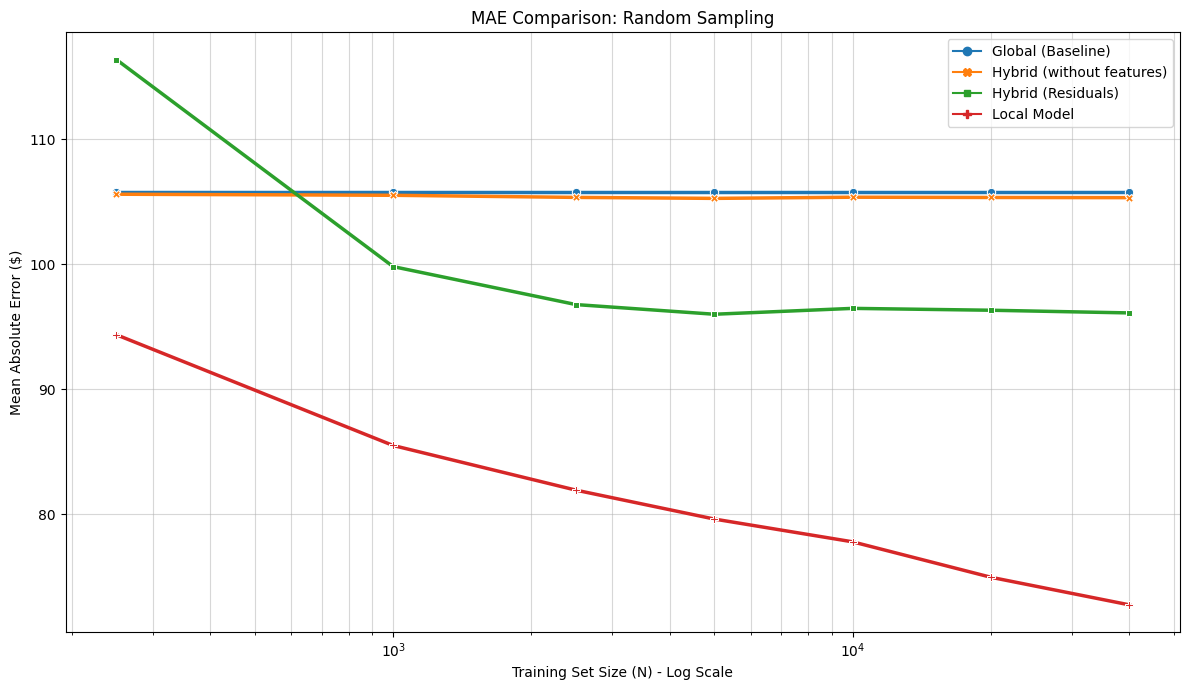

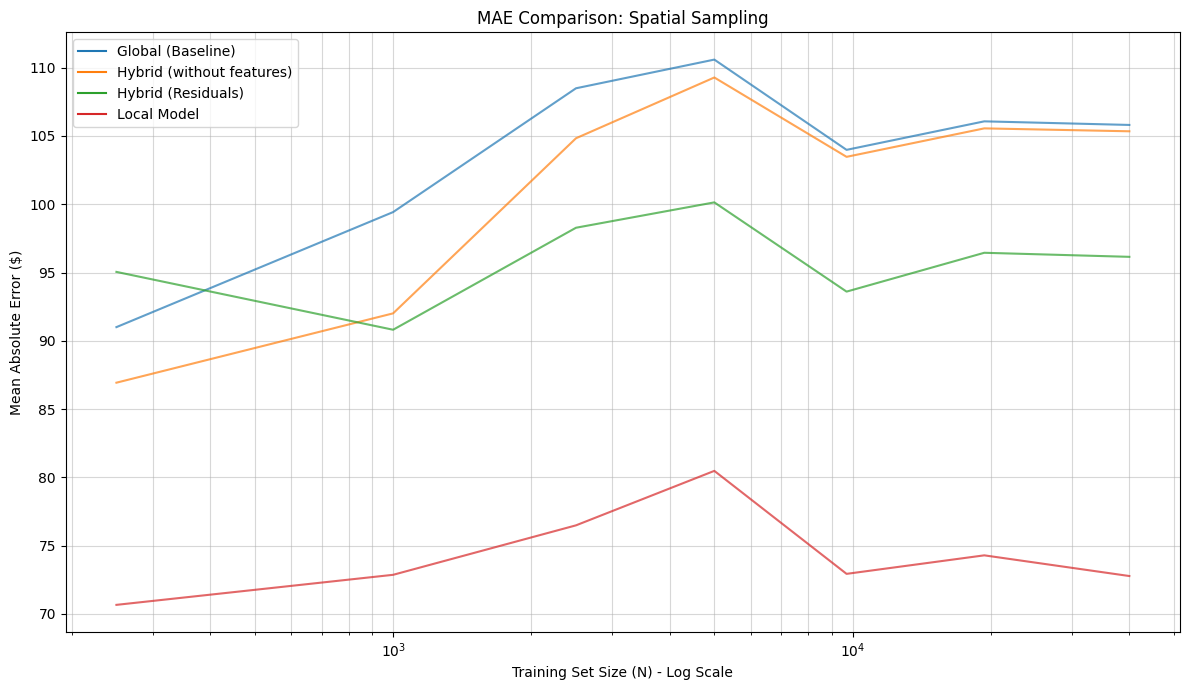

In [0]:
# --- 4. Aggregation & Visualization ---
# Group by Sampling Method, Model, and Size to get mean metrics
agg_results = final_results_df.groupby(['sampling_method', 'model', 'iteration'])[['dollar_mae', 'dollar_rmse', 'dollar_r2','n_size']].mean().reset_index()

# Rename the models
model_name_mapping = {
    'Local Standalone': 'Local Model',
    'Global (baseline)': 'Global Model',
    'Hybrid (residuals)': 'Hybrid (with features)',
    'Global Calibrated (POC)': 'Hybrid (without features)'
}
agg_results['model'] = agg_results['model'].replace(model_name_mapping)

print("\n--- Top Results (Lowest MAE) ---")
display(agg_results.sort_values('dollar_mae'))

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

# Plot Random Sampling (Solid Lines)
sns.lineplot(
    data=agg_results[agg_results['sampling_method'] == 'random'], 
    x='n_size', y='dollar_mae', hue='model', style='model', 
    markers=True, dashes=False, linewidth=2.5
)

plt.xscale('log')
plt.title('MAE Comparison: Random Sampling')
plt.ylabel('Mean Absolute Error ($)')
plt.xlabel('Training Set Size (N) - Log Scale')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend(loc='best')  # Changed to 'best' to place legend inside plot
plt.tight_layout()
plt.show()

# Plot Spatial Sampling (Dotted/Different Lines) - Optional overlay or separate plot
# Since Spatial N varies, we plot it as scatter points or separate lines to compare
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=agg_results[agg_results['sampling_method'] == 'spatial'], 
    x='n_size', y='dollar_mae', hue='model', 
    markers=True, linestyle='-', alpha=0.7, linewidth=1.5
)

plt.xscale('log')
plt.title('MAE Comparison: Spatial Sampling')
plt.ylabel('Mean Absolute Error ($)')
plt.xlabel('Training Set Size (N) - Log Scale')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend(loc='best')  # Changed to 'best' to place legend inside plot
plt.tight_layout()
plt.show()